<a href="https://colab.research.google.com/github/BitanSarkar/BrainTumorDetect/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taking data from drive. 
# Pre-processing of data using sklearn.preprocessing


In [24]:
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

DIRECTORY = r"/content/drive/My Drive/brain_tumor_dataset"
CATEGORIES = ["yes", "no"]

print("[INFO] loading images...")

data = []
labels = []
ctr=0
for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category)
  for img in os.listdir(path):
    ctr+=1
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(category)
    if ctr%500==0:
      print("Data loaded upto = " + str(ctr))
    if ctr == 3000:
      print("Data Loading COMPLETED")



[INFO] loading images...
Data loaded upto = 500
Data loaded upto = 1000
Data loaded upto = 1500
Data loaded upto = 2000
Data loaded upto = 2500
Data loaded upto = 3000
Data Loading COMPLETED


# Label Binarizer to change "yes", "no" to 1s and 0s.

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Splitting of dataset into training and testing datas and generate image augmentation as the number of images in dataset is less.

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.10, stratify=labels, random_state=42)
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

# Using Neurons from MobileNetV2 to create layers

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224,3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(87, activation="relu")(headModel) #layer 1
headModel = Dropout(0.5)(headModel)

headModel = Dense(34, activation="relu")(headModel) #layer 2
headModel = Dropout(0.4)(headModel)

headModel = Dense(13, activation="relu")(headModel) #layer 3
headModel = Dropout(0.3)(headModel)

headModel = Dense(5, activation="relu")(headModel)  #layer 4
headModel = Dropout(0.2)(headModel)

headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False


9412608/9406464 [==============================] - 0s 0us/step


#Traing on CNN using the data-set 
# Learning rate = 0.0001
# Epochs = 1000
# Batch size = 50

In [ ]:
print("[INFO] compiling model...")


INIT_LR = 1e-4
EPOCHS = 1000
BS = 50


opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] compiling model...
[INFO] training head...
Epoch 1/1000
54/54 [==============================] - 26s 482ms/step - loss: 0.8014 - accuracy: 0.5115 - val_loss: 0.6864 - val_accuracy: 0.5467
Epoch 2/1000
54/54 [==============================] - 26s 483ms/step - loss: 0.7136 - accuracy: 0.5352 - val_loss: 0.6649 - val_accuracy: 0.6067
Epoch 3/1000
54/54 [==============================] - 26s 480ms/step - loss: 0.6887 - accuracy: 0.5574 - val_loss: 0.6524 - val_accuracy: 0.6233
Epoch 4/1000
54/54 [==============================] - 26s 478ms/step - loss: 0.6663 - accuracy: 0.5956 - val_loss: 0.6366 - val_accuracy: 0.7167
Epoch 5/1000
54/54 [==============================] - 26s 478ms/step - loss: 0.6500 - accuracy: 0.6163 - val_loss: 0.6114 - val_accuracy: 0.7400
Epoch 6/1000
54/54 [==============================] - 26s 479ms/step - loss: 0.6481 - accuracy: 0.6341 - val_loss: 0.5681 - val_accuracy: 0.7767
Epoch 7/1000
54/54 [==============================] - 26s 478ms/step - loss: 0.6

#Saving the model that has been made

In [ ]:
print("[INFO] saving mask detector model...")
model.save("tumor_detector.model", save_format="h5")

[INFO] saving mask detector model...


# Plotting the accuracy of the model

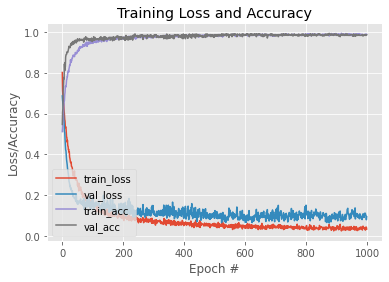

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# Main Brain Tumour Detection Code from MRI scan


In [21]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from google.colab import files
import numpy as np

model_path = r"/content/drive/My Drive/brain_tumor_dataset/tumor_detector.model"
tumorNet = load_model(model_path)

x = files.upload()
path = ''
for key, val in x.items():
  path=key

img = load_img(path, target_size=(224, 224))
img = img_to_array(img)
img = preprocess_input(img)
I = [img]
I = np.array(I, dtype="float32")
[[no,yes]] = tumorNet.predict(I, batch_size = 20)
if yes>no:
  print("Tumor detected, with probabilty of " + str(yes*100) + "%")
else:
  print("No tumor detected, with probabilty of " + str(no*100) + "%")

Saving pred14.jpg to pred14.jpg
Tumor detected, with probabilty of 100.0%
